In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shapereader
import shapely.affinity as shp
plt.style.use('bmh')
_DEFAULT_PROJECTION = ccrs.Mercator().GOOGLE
%matplotlib inline

In [15]:
shapename = 'admin_1_states_provinces_lakes_shp' # specified at http://naturalearthdata.com 
states_shp = shapereader.natural_earth(resolution='110m',
                                       category='cultural',
                                       name=shapename)
reader = shapereader.Reader(states_shp)
countries = reader.records() 

In [16]:
df = pd.read_csv("./data/final_loc_data.csv")
pd.to_datetime(df.time)
df.head() 

,time,site,precip,rh,solrad,temp,lat,lon,city,state
0,1961-01-01,3103,NaN,NaN,NaN,NaN,35.08,111.4,FLAGSTAFF,AZ
1,1961-02-01,3103,NaN,NaN,NaN,NaN,35.08,111.4,FLAGSTAFF,AZ
2,1961-03-01,3103,NaN,NaN,NaN,NaN,35.08,111.4,FLAGSTAFF,AZ
3,1961-04-01,3103,NaN,NaN,NaN,NaN,35.08,111.4,FLAGSTAFF,AZ
4,1961-05-01,3103,NaN,NaN,NaN,NaN,35.08,111.4,FLAGSTAFF,AZ


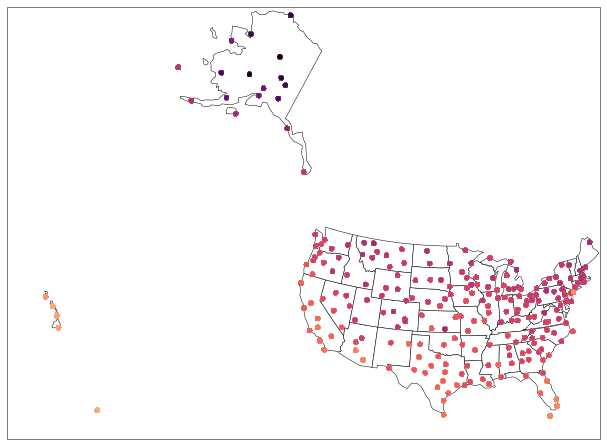

In [17]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())  
ax.set_extent([-165, -75, 20, 70], ccrs.Geodetic())  
 
AKratio = 1
HIratio = 1
# AKtrans = [38,-35]
# HItrans = [48,4]
AKtrans = [0,0]
HItrans = [0,0]
 
df2 = df.copy() 

df2.loc[ df2['state'] == 'AK','lon']  =  df[df['state'] == 'AK'].lon - AKtrans[0]
df2.loc[ df2['state'] == 'AK','lat']  =  df[df['state'] == 'AK'].lat + AKtrans[1] 
df2.loc[ df['state'] == 'HI','lon']  =  df[df['state'] == 'HI'].lon   -HItrans[0]
df2.loc[ df['state'] == 'HI','lat']  =  df[df['state'] == 'HI'].lat  + HItrans[1]
     
for state in shapereader.Reader(states_shp).records():   
    if  state.attributes['name'] =='Alaska':  
        tempGeom = shp.translate( state.geometry, AKtrans[0], AKtrans[1])  
        tempGeom2= shp.scale(tempGeom, xfact=AKratio, yfact=AKratio, zfact=AKratio, origin='center')
        ax.add_geometries( tempGeom2, ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor='k') 
        
        centr = tempGeom.centroid 
        df2.loc[df2['state'] == 'AK','lon'] = (df2.loc[ df2['state'] == 'AK','lon'] +
                            centr.coords[0][0]   )*AKratio  - centr.coords[0][0] 
        df2.loc[df2['state'] == 'AK','lat'] = (df2.loc[ df2['state'] == 'AK','lat'] -
                            centr.coords[0][1]   )*AKratio  + centr.coords[0][1] 
         
    elif  state.attributes['name'] =='Hawaii':    
        tempGeom = shp.translate( state.geometry, HItrans[0],HItrans[1]) 
        tempGeom2= shp.scale(tempGeom, xfact=HIratio, yfact=HIratio, zfact=HIratio, origin='center')
        ax.add_geometries( tempGeom2, ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor='k') 
        
        centr = tempGeom.centroid 
        df2.loc[df2['state'] == 'HI','lon'] = (df2.loc[ df2['state'] == 'HI','lon'] +
                            centr.coords[0][0]   )*AKratio  - centr.coords[0][0] 
        df2.loc[df2['state'] == 'HI','lat'] = (df2.loc[ df2['state'] == 'HI','lat'] -
                            centr.coords[0][1]   )*AKratio  + centr.coords[0][1] 
    else:  
        ax.add_geometries([state.geometry], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor='k')
        
# ax.scatter( - df2['lon'], df2['lat'], transform=ccrs.PlateCarree(), 
#            c=df2['temp'], s=df2['precip'], cmap='magma',zorder = 10)
ax.scatter( - df2['lon'], df2['lat'], transform=ccrs.PlateCarree(), 
           c=df2['temp'], s=20, cmap='magma',zorder = 10)

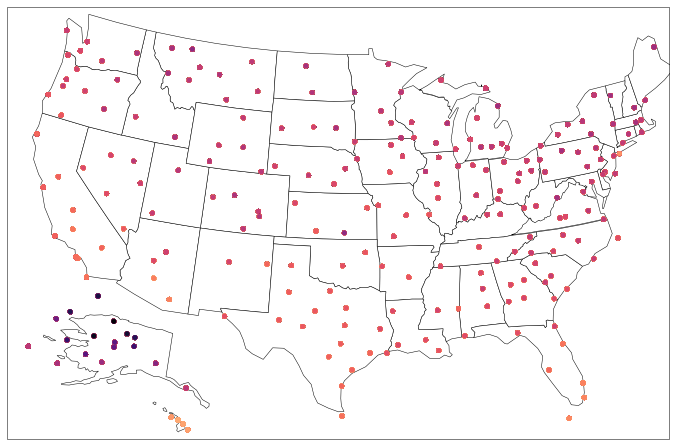

In [22]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())  
ax.set_extent([-120, -75, 22, 50], ccrs.Geodetic())  
  
AKfactor = 0.3 
HIfactor = 0.5
AKtrans = [38,-35]
HItrans = [48,4]
 
df2 = df.copy() 

df2.loc[ df2['state'] == 'AK','lon']  =  df[df['state'] == 'AK'].lon - AKtrans[0]
df2.loc[ df2['state'] == 'AK','lat']  =  df[df['state'] == 'AK'].lat + AKtrans[1] 
df2.loc[ df['state'] == 'HI','lon']  =  df[df['state'] == 'HI'].lon   -HItrans[0]
df2.loc[ df['state'] == 'HI','lat']  =  df[df['state'] == 'HI'].lat  + HItrans[1]
     
for state in shapereader.Reader(states_shp).records():   
    if  state.attributes['name'] =='Alaska':  
        tempGeom = shp.translate( state.geometry, AKtrans[0], AKtrans[1])  
        tempGeom2= shp.scale(tempGeom, xfact=AKfactor, yfact=AKfactor, zfact=AKfactor, origin='center')
        ax.add_geometries( tempGeom2, ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor='k') 
        
        centr = tempGeom.centroid 
        df2.loc[df2['state'] == 'AK','lon'] = (df2.loc[ df2['state'] == 'AK','lon'] +
                            centr.coords[0][0]   )*AKfactor  - centr.coords[0][0] 
        df2.loc[df2['state'] == 'AK','lat'] = (df2.loc[ df2['state'] == 'AK','lat'] -
                            centr.coords[0][1]   )*AKfactor  + centr.coords[0][1] 
        
    elif  state.attributes['name'] =='Hawaii':    
        tempGeom = shp.translate( state.geometry, HItrans[0],HItrans[1]) 
        tempGeom2= shp.scale(tempGeom, xfact=HIfactor, yfact=HIfactor, zfact=HIfactor, origin='center')
        ax.add_geometries( tempGeom2, ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor='k') 
        
        centr = tempGeom.centroid 
        df2.loc[df2['state'] == 'HI','lon'] = (df2.loc[ df2['state'] == 'HI','lon'] +
                            centr.coords[0][0]   )*AKfactor  - centr.coords[0][0] 
        df2.loc[df2['state'] == 'HI','lat'] = (df2.loc[ df2['state'] == 'HI','lat'] -
                            centr.coords[0][1]   )*AKfactor  + centr.coords[0][1] 
    else:  
        ax.add_geometries([state.geometry], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor='k')
        
# ax.scatter( - df2['lon'], df2['lat'], transform=ccrs.PlateCarree(), 
#            c=df2['temp'], s=df2['precip'], cmap='magma',zorder = 10)

ax.scatter( - df2['lon'], df2['lat'], transform=ccrs.PlateCarree(), 
           c=df2['temp'], s=20, cmap='magma',zorder = 10)